In [232]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 100})

# 1. Bayesian Theorem

## 1.1 Task

$$
P(I|E) = P(E|I)\frac{P(I)}{P(E)}, where
$$

$ P(I) - \mbox{probablity that man is innocent not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|I) - \mbox{probability that test is observed given that man is innocent (false positive result)} $
$ P(I|E) - \mbox{probability that man is innocent given despite the test is observed} $

$ \mbox{We see that } P(E|I) \mbox{ is small - that prosecitor evaluated. Prosecutor mistakes when tells that }  P(I|E) \mbox{ is small - that prosecutor should evaluate.} $ \
$ \mbox{In fact } P(E|I) \mbox{ and} P(I|E) \mbox{ are different from each other.} $ \
$ \mbox{Equation above shows that small } P(E|I) \mbox{ does not imply small } P(I|E) \mbox{ in case of big value of } P(I) \mbox{ and small value } P(E). $ 
$ \mbox{I.E if in other case man can be innocent and hardly somebody presents observed evidence.} $

## 1.2 Task

$$
P(G|E) = P(E|G)\frac{P(G)}{P(E)}, where
$$

$ P(G) - \mbox{probablity that man is guilty not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|G) - \mbox{probability that test is observed given that man is guilty} $ \
$ P(G|E) - \mbox{probability that man is innocent given despite the test is observed} $

$ \mbox{We see that } P(E|G) \mbox{ is small - that defender evaluated. Defender mistakes when tells that }  P(G/E) \mbox{ is small - that defender should evaluate.} $ \ 
$ \mbox{In fact } P(E/G) \mbox{ and } \mbox{ P(G/E) } \mbox{ are different from each other.} $ \
$ \mbox{In defender's calculation prior guilty probability does not taken into account. If for example police presents list of 10 suspects that had access} $ 
$ \mbox{to crime place then it would not be logically to suppose that test that gives 1/1000000 on success would change prior probablity from 1/10 to 1/1000000.} $  

## 1.3 Task

In [222]:
def aposterior_positive_prob(false_positive):
    return ((1 - false_positive) * 0.01) / ((1 - false_positive) * 0.01 + false_positive * 0.99)

In [223]:
def aposterior_negative_prob(false_negative):
    return (false_negative * 0.01) / (false_negative * 0.01 + (1 - false_negative) * 0.99)

In [224]:
x = np.arange(0, 0.05, 0.0001)

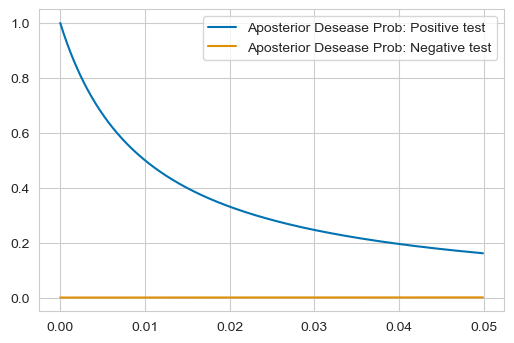

In [233]:
plt.plot(x, aposterior_positive_prob(x))
plt.plot(x, aposterior_negative_prob(x))
plt.legend(["Aposterior Desease Prob: Positive test", "Aposterior Desease Prob: Negative test"])

##### We can see that aposterior_positive_prob changes significantly with the growth of false_positive value
##### and vice versa  aposterior_negative_prob changes not much, so conclusion to concentrate on reducing false_positives

# 2. Linear Regression

### 2.1 Train Linear Model y ~ exp(linear function(x))

### Total Cases

In [430]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [431]:
target = 'total_cases'

In [432]:
df = df.dropna(subset=['total_cases'])
df = df.reset_index(drop=True)

In [433]:
date_format = "%Y-%m-%d"
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-03-31']
df = df.reset_index(drop=True)
df['current_date'] = (df['date'] - df['date'].min()).dt.days + 1

In [434]:
russia = df[(df['location'] == 'Russia')].reset_index(drop=True)

In [435]:
train = df[(df['location'] == 'Russia') & (df['current_date'] <= 50)].reset_index(drop=True)
test = df[(df['location'] == 'Russia') & (df['current_date'] > 50)].reset_index(drop=True)

In [436]:
regr = linear_model.LinearRegression()
X = train['current_date'].values.reshape(-1, 1)
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)
train['predicted'] = train['current_date'] * float(regr.coef_) + float(regr.intercept_)

In [437]:
cur_mu, cur_sigma = np.array([0, 0]), 10*np.array([[1, 0], [0, 1]])
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [438]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [439]:
for i in range(len(train)):
    px, py = train['current_date'][i], np.log(train[target][i])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
print(cur_mu, cur_sigma)

[8.32201661 0.09760175] [[ 7.78257701e-03 -2.31165603e-04]
 [-2.31165603e-04  9.06703049e-06]]


In [440]:
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

px, py = float(russia[russia['date'] == '2020-05-01']['current_date']), float(np.log(russia[russia['date'] == '2020-05-01'][target]))
px2, py2 = float(russia[russia['date'] == '2020-06-01']['current_date']), float(np.log(russia[russia['date'] == '2020-06-01'][target]))
px3, py3 = float(russia[russia['date'] == '2020-09-01']['current_date']), float(np.log(russia[russia['date'] == '2020-09-01'][target]))
#cur_likelihood = get_likelihood(px, py)
#Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

In [441]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [442]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 160))
    ax.set_ylim((1, 50))
    ax.plot(xs, np.array(np.log(russia[target])), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - sigma_noise, mu[1]*xs + mu[0] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

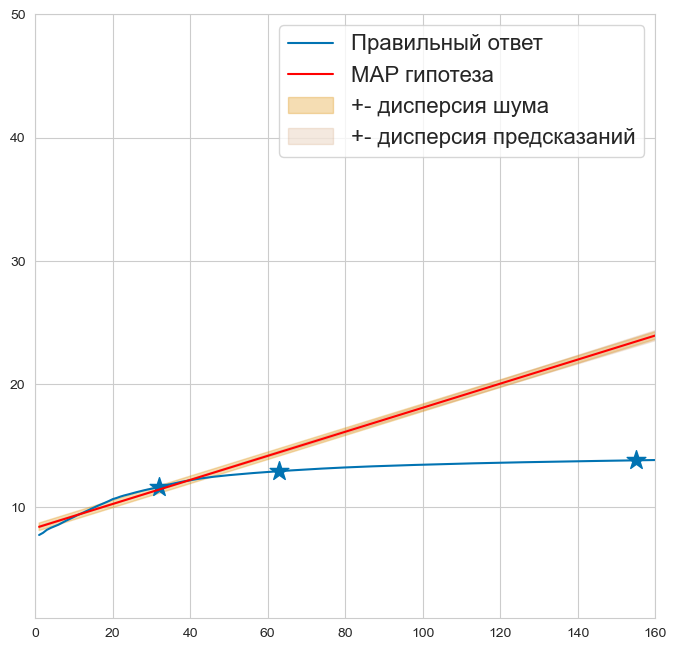

In [443]:
xs = np.array(russia['current_date'])
x = sample_statistics(cur_mu, cur_sigma, np.array(russia['current_date']), n=1000)
plot_predictions(xs, cur_mu, x, [[px, px2, px3], [py, py2, py3]])
#plot_predictions(np.array(russia['current_date']), cur_mu, x, [[px], [py]])

### New Cases

In [444]:
target = 'new_cases'

In [445]:
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)
train['predicted'] = train['current_date'] * float(regr.coef_) + float(regr.intercept_)

In [446]:
cur_mu, cur_sigma = np.array([0, 0]), 10*np.array([[1, 0], [0, 1]])
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [447]:
for i in range(len(train)):
    px, py = train['current_date'][i], np.log(train[target][i])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
print(cur_mu, cur_sigma)

[6.72557794 0.06331385] [[ 7.78257701e-03 -2.31165603e-04]
 [-2.31165603e-04  9.06703049e-06]]


In [448]:
px, py = float(russia[russia['date'] == '2020-05-01']['current_date']), np.log(float(russia[russia['date'] == '2020-05-01'][target]))
px2, py2 = float(russia[russia['date'] == '2020-06-01']['current_date']), np.log(float(russia[russia['date'] == '2020-06-01'][target]))
px3, py3 = float(russia[russia['date'] == '2020-09-01']['current_date']), np.log(float(russia[russia['date'] == '2020-09-01'][target]))

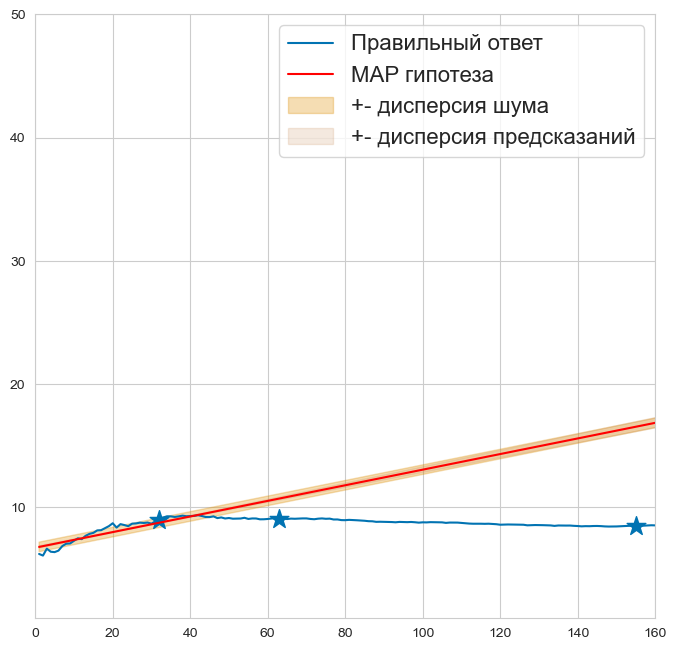

In [449]:
x = sample_statistics(cur_mu, cur_sigma, np.array(russia['current_date']), n=1000)
plot_predictions(np.array(russia['current_date']), cur_mu, x, [[px, px2, px3], [py, py2, py3]])